<a href="https://colab.research.google.com/github/N-Efi/N-Efi/blob/main/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D1%84%D0%BB%D0%BE%D1%80%D0%B8%D1%81%D1%82_CVAE_%D0%B8%D1%82%D0%BE%D0%B3%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Дипломный проект "Нерофлорист"

Студент Университета Искусственного Интеллекта Ника Витальевна Ефимова

Старт обучения - май 2021г.

Задача: генерация букетов с заданными цветами. 
В нашем случае - 24 типа монобукетов с двумя признаками: вид цветов (растений) и основной цвет букета

Защита 14.01.2022.

# 1. Подключение необходимых библиотек

In [ ]:
# Подключение библиотек
import os # 
import numpy as np #
import tensorflow as tf # для работы с Тензорфлоу
from tensorflow.keras import utils # для работы с утилитами
from tensorflow.keras.preprocessing import image # для обработки изображений
from tensorflow.keras.preprocessing import image_dataset_from_directory # может потребоваться для загружки БД
import matplotlib.pyplot as plt # импорт библиотеки Матплотлиб для отрисовки графиков и изображений
from google.colab import files # для работы с файлами
from tensorflow.keras.preprocessing.image import ImageDataGenerator # для подачи входных данных с помощью генератора
from PIL import Image #Для отрисовки изображений
from tensorflow.keras import layers # импортируем слои 
from tensorflow.keras import models # импортируем модели
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy, mse, mae # импортируем функции ошибок
from tensorflow.keras.optimizers import Adam # импорт оптимизатора
from tensorflow.keras.callbacks import LambdaCallback # для написания Callback
from IPython.display import clear_output, Image # для очистки выхода сети
from tensorflow.keras.utils import to_categorical # для преобразования меток в OHE
import tensorflow.keras.backend as K # для написания собственного слоя
from sklearn.metrics import confusion_matrix # для написания метрик
from tensorflow.keras.initializers import RandomNormal #Импортируем слой инициализации весов с номральным распределением
from tensorflow.keras.layers import  Activation # подключаем активации
from tensorflow.keras.layers import Dense, Input, Lambda, Flatten, Reshape # поключаем нужные нам слои
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, concatenate # поключаем нужные нам слои
from tensorflow.keras.models import Model # для работы с моделями
import time # Имортируем, чтобы высчитать время работы каких-либо процессов
%matplotlib inline 

In [ ]:
from google.colab import drive # подключение диска для работы с изображениями БД
drive.mount('/content/drive')

Mounted at /content/drive


# 2.Загрузка и подготовка выходных данных

In [ ]:
# распаковываем базу с входными изображениями
!unzip -q '/content/drive/MyDrive/ДИПЛОМ AI/DS_Flowers_2signs.zip' -d '/content/DS_Flowers_2signs' 

In [ ]:
path = '/content/DS_Flowers_2signs/DS_Flowers_2signs'# указываем путь к распакованной базе изображений
batch_size = 32 #Размер выборки
img_width = 128 #Ширина изображения
img_height = 128 #Высота изображения

# Применяем ImageDataGenerator для экономии памяти при подаче входных данных
datagen = ImageDataGenerator(
    rescale = 1/259, #(1 - 127.5)/127.5, #Значения цвета меняем на дробные показания, приводим к макс.значению 0,98 (чтобы сохранить чувствительность к метке класса OHE)
    rotation_range=10, #Поворачиваем изображения при генерации выборки
    width_shift_range=0.1, #Двигаем изображения по ширине при генерации выборки
    height_shift_range=0.1, #Двигаем изображения по высоте при генерации выборки
    zoom_range=0.1, #Зумируем изображения при генерации выборки
    horizontal_flip=True, #Включаем отзеркаливание изображений
    fill_mode='nearest', #Заполнение пикселей вне границ ввода
    validation_split=0.2 #Указываем разделение изображений на обучающую и тестовую выборку
)
# тренировочная выборка
train  = datagen.flow_from_directory(
    path, #Путь ко всей выборке выборке
    target_size=(img_width, img_height), #Размер изображений
    batch_size=batch_size, #Размер batch_size
    class_mode='categorical', #Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=True, #Перемешивание выборки
    subset='training' # устанавливаем как набор для обучения
)

# проверочная выборка
valid = datagen.flow_from_directory(
    path, #Путь ко всей выборке выборке
    target_size=(img_width, img_height), #Размер изображений
    batch_size=batch_size, #Размер batch_size
    class_mode='categorical', #Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=True, #Перемешивание выборки
    subset='validation' #устанавливаем как валидационный набор
 ) 
# определяем классы по номеру папок БД, где хранятся изображения
num_classes = len(os.listdir(path))

Found 712 images belonging to 24 classes.
Found 165 images belonging to 24 classes.


In [ ]:
# Подготавливаем данные для работы нейросети
f = train.next()
f_test = valid.next()
print(f[0].shape)
print(f[1].shape)

(32, 128, 128, 3)
(32, 24)


In [ ]:
# Подготавливаем данные для работы нейросети
xtrain, ytrain = f[0], f[1]
xtest, ytest = f_test[0], f_test[1]

print('xtrain.shape:', xtrain.shape)
print('xtest.shape:', xtest.shape)
print('ytrain.shape:', ytrain.shape)
print('ytest.shape:', ytest.shape)

xtrain.shape: (32, 128, 128, 3)
xtest.shape: (32, 128, 128, 3)
ytrain.shape: (32, 24)
ytest.shape: (32, 24)


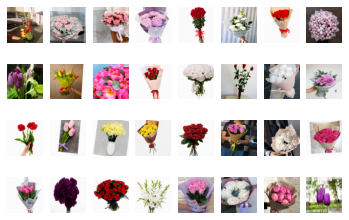

In [ ]:
# Выведем для примера изображения, хранящиеся в БД
for i, im in enumerate(f[0]):
  plt.subplot(4, 8, i+1)
  plt.imshow(im)
  plt.axis('off')
plt.show()

Задание параметров нейросети

In [ ]:
batch_size = 32 # количество тренировочных изображений для обработки перед обновлением параметров модели
img_rows = 128 # Высота изображения в пикселях
img_cols = 128 # Ширина изображения в пикселях
channels = 3 # Количество каналов (глубина изображения)
img_shape = (img_rows, img_cols, channels) # Размерность входных данных 
latent_dim = 2024 # Размерность скрытого пространства
num_classes = 24 # Количество классов изображений
optimizer = Adam(0.0002, 0.5) # Оптимайзер
dropout_rate = 0.3 # доля выключаемых нейронов для слоя Dropout
start_lr = 0.0001 # шаг обучения
latent_distrs = [] # список, в котором будем сохранять результаты преобразования изображений, для последующей визуализации
save_epochs = 20 # количество эпох, через которое будем сохранять результаты преобразования изображений
#conv_init = RandomNormal(mean=0.0, stddev=0.02) # при тестировании сверточной НС
#gamma_init = RandomNormal(1., 0.02) # при тестировании сверточной НС

In [ ]:
num_classes = ytest.shape[1] # задаем количество классов
num_classes

24

In [ ]:
!mkdir images #  создаем каталог images для сохранения получившихся изображений

# 3. Функции, используемые при формировании нейросети, обработке и выводе результатов

In [ ]:
# функция добавления слоев Dropout и BatchNormalization
def apply_bn_and_dropout(x):
  '''
  apply_bn_and_dropout - функция добавления слоев Dropout и BatchNormalization
    вход:
      x - набор слоев, после которых необходимо добавить Dropout и BatchNormalization
      dropout_rate - доля отключенных нейронов (берется из родительской функции)
    выход:
      x - набор слоев с добавленными Dropout и BatchNormalization
  '''
  x = Dropout(dropout_rate) (x) # к слою x добавляем Dropout
  x = BatchNormalization() (x) # к слою x добавляем BatchNormalization
  return x

# функция создания собственного слоя
def sampling(args):
  '''
  sampling - функция создания собственного слоя
    вход:
      args - два слоя из котрых возьмем мат.ожидание и ст.отклонение
    выход:
      sampling_layer - собственный слой
  '''
  z_mean, z_log_var = args # раскусываем поданные на вход слои
  epsilon = K.random_normal(shape=(latent_dim,), mean=0., stddev=1.0) # керасовским методом делаем нормальное распределение c мат.ожиданием 0, ст.отклонением 1
  sampling_layer = z_mean + K.exp(z_log_var / 2) * epsilon # изменяем мат.ожидание и ст.отклонение путем сложения и произведения 
  return sampling_layer

# собственная функция ошибки для вариацинного автокодировщика (VAE)
def vae_loss(x, decoded):
  '''
  vae_loss - функция ошибки для VAE
    вход:
      x - истинные картинки (те, что поданы в качестве y)
      decoded - картинки, созданные VAE
    выход:
      res - значение ошибки
  '''
  # num_elements это наши метки, что мы через global получаем за каждую эпоху
  # по формуле кульбака-лейблера устанавливаем ошибку kl_loss
  kl_loss = -0.5 * K.sum(1.0 + z_log_var_model([x,num_elements]) - K.square(z_mean_model([x,num_elements])) - K.exp(z_log_var_model([x,num_elements])), axis=-1) 
  x = K.reshape(x, (-1, img_rows* img_cols*channels)) # меняем форму для последующего соответствия размеров
  decoded = K.reshape(decoded, (-1, img_rows*img_cols*channels)) # меняем форму для последующего соответствия размеров
  xent_loss =img_rows*img_cols*channels*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
  # получаем суммарную ошибку с учетом распределения и размеров пикселей, управляем соотношением xent_loss и kl_loss для улучшения качества результата
  res = (0.25*xent_loss + 0.75*kl_loss)/img_rows/img_cols/channels # получаем суммарную ошибку с учетом распределения и размеров пикселей
  return res

In [ ]:
from random import randint

def sample_images_conditional(epoch, decoder):  # Функция печати изображений
  r, c = 4, 8 # Параметры вывода (количество строк (r) и количество столбцов (c)) (r*c = batch_size)
  noise = np.random.normal(0, 2, (batch_size, latent_dim)) # Создаем вектор размерностью (r*c,latent_dim (10,100)) из нормально распределенных значений
  sampled_labels = np.random.randint(0, 24, (batch_size, num_classes)) # Создаем массив мeток от 0 до 24 
  
  gen_imgs = decoder.predict([noise, sampled_labels]) # Предиктим картинку с помощью входной переменной decoder

  fig, axs = plt.subplots(r, c) # Создаем окно вывода r на c (4 на 8) ячеек
  cnt = 0 # Порядковый номер картинки
  for i in range(r):
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt, :,:,:]) # Записываем в axs[i,j] сгенерироввнное изображение из gen_img с индексом cnt
          axs[i,j].axis('off') # Отключаем печать названия осей
          cnt += 1 # Увеличиваем индекс изображения
  plt.show()  # Рисуем сгенерированные изображения
  fig.savefig("images/%d.png" % epoch) # Сохраняем изображения в папке images
  #plt.close()# Завершаем работу с plt

In [ ]:
# коллбэк
epoch = 0
num_elements = K.constant(ytrain[batch_size*epoch:batch_size*(epoch+1)])
def on_epoch_end(epoch, logs):
  '''
  on_epoch_end - функция-callback для отрисовки полученных результатов
    вход:
      epoch - текущая эпоха
      logs - текущее состояние параметров (loss, val_loss)
    выход:
      отрисовка изображений, полученных в результате работы VAE
  '''
  global num_elements
  curTime = time.time() # Запоминаем текущее время
  num_elements = K.constant(ytrain[batch_size*epoch:batch_size*(epoch+1)])  # каждый раз переопределяем все метки, чтобы обучение шло хорошо
  if epoch % save_epochs == 10: # если текущая эпоха кратная save_epochs (не равно 0, чтобы не печатать изображения в целях экономии вычислит.ресурсов)
    clear_output() # очищаем вывод
    # применялось на более ранних этапах тестирования для текущего отслекживания результатов
    real_img = xtest[:10] # берем первые 10 изображений из x_test
    real_img_nums = ytest[:10] # еще раз берем первые 10 изображений из x_test
    pred_img = CVAE.predict([real_img, real_img_nums, real_img_nums]) # пропускаем их через CVAE

    real_img_concat = np.concatenate([i for i in real_img[:,:,:,0]], axis=1) # объединяем 10 исходный изображений по оси 1
    pred_img_concat = np.concatenate([i for i in pred_img[:,:,:,0]], axis=1) # объединяем 10 изображений, пропущенных через СVAE, по оси 1
    plot_img = np.concatenate((real_img_concat, pred_img_concat), axis=0) # объединяем два полученных изображения в одно по оси 0
    latent_distrs.append(plot_img) # итоговое изображение добавляем в список для последующего анимирования результата

    plt.figure(figsize=(2*img_height, 2*len(real_img)), dpi=25) # создаем фигуру
    plt.imshow(plot_img) #, cmap='rgb') # отрисовываем итоговое изображение
    plt.grid(False) # убираем сетку
    plt.axis('off') # выключаем оси
    plt.show() # выводим результат
    print('Обучение НС заняло: ', round(time.time() - curTime, 2), 's') # выводим время, которое заняло обучение НС

pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
# Обучение CVAE и вывод результатов
def train_cvae(CVAE,  epochs=1, batch_size=32, callbacks=[pltfig]): # Функция обучения
    curTime = time.time() # Запоминаем текущее время
    
    sample_interval = 5 # Указываем интервал, через который будем текущие сгенерированые изображения
      
    for epoch in range(epochs):
   
      idx = np.random.randint(0, xtrain.shape[0], batch_size) # генерируем метку для связывания изображения с номером класса
      imgs = xtrain[idx] # определяем изображение по метке
      labels = ytrain[idx] # определяем класс по метке
      
      idx_test = np.random.randint(0, xtest.shape[0], batch_size) # генерируем метку для связывания изображения с номером класса
      imgs_test, labels_test = xtest[idx_test], ytest[idx_test] # определяем изображение и класс по метке
      
      #  Обучение CVAE
      CVAE.fit([imgs, labels, labels], imgs, batch_size=batch_size, epochs=1, callbacks=[pltfig], 
          validation_data=([imgs_test, labels_test, labels_test], imgs_test))
      
      print (epoch) # печатаем номер текущей эпохи
      
      # Проверяем на условие вывода информации раз в sample_interval эпох
    if ((epoch % sample_interval == 0) | (epoch == epochs-1)):
      sample_images_conditional(epoch, decoder)
              
  
    print('Обучение НС заняло: ', round(time.time() - curTime, 2), 's') # выводим время, которое заняло обучение НС

# 4. Нейросеть CVAE

In [ ]:
# Создание энкодера на полносвязных слоях
en_in = Input((img_rows, img_cols, channels)) # входной слой
en = Flatten() (en_in) # разворачиванние входного массива для использования полносвязных слоев
# Дополнительным входом подаём метки в виде OHE на 24 элемента(кол-во классов) и умножаем на 2, чтобы сеть лучше реагировала на метки классов
class_1 = Input(shape=(num_classes,))*2  
en = concatenate([en, class_1]) # Соединяем входные слои
# не используем первые 2 слоя нормализацию для более качественного распределения в соответствии с метками классов
en = Dense(512, activation='relu') (en) # подключение полносвязного слоя на 256 нейронов
en = Dense(256, activation='relu') (en) # подключение полносвязного слоя на 256 нейронов
en = Dense(128, activation='relu') (en) # подключение полносвязного слоя на 128 нейронов
en = apply_bn_and_dropout(en) # добавление слоев Dropout и BatchNormalization

z_mean = Dense(latent_dim) (en) # скрытое пространство (мат.ожидание) размером latent_dim
z_log_var = Dense(latent_dim) (en) # скрытое пространство (лог.вариации) размером latent_dim

# задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (latent_dim,)
l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])  

# Создание декодера на полносвязных слоях
dec_in = Input(shape =(latent_dim,)) # задаем входную размерность
# Дополнительным входом подаём метки в виде OHE на 24 элемента(кол-во классов) и умножаем на 2, чтобы сеть лучше реагировала на метки классов
class_2 = Input(shape=(num_classes,))*2 
dec = concatenate([dec_in, class_2]) # Соединяем входные слои
dec = Dense(128) (dec) # полносвязный слой на 128 нейронов
dec = LeakyReLU()(dec) # применяем функцию активации отдельным слоем
dec = apply_bn_and_dropout(dec) # добавление слоев Dropout и BatchNormalization
dec = Dense(256) (dec) # полносвязный слой на 256 нейронов
dec = LeakyReLU()(dec) # применяем функцию активации отдельным слоем
dec = apply_bn_and_dropout(dec) # добавление слоев Dropout и BatchNormalization
dec = Dense(512) (dec) # полносвязный слой на 256 нейронов
dec = LeakyReLU()(dec) # применяем функцию активации отдельным слоем
dec = apply_bn_and_dropout(dec) # добавление слоев Dropout и BatchNormalization
dec = Dense(img_rows* img_cols*channels, activation='sigmoid') (dec) # полносвязный слой на 49152 нейрона
decoded = Reshape((img_rows, img_cols, channels)) (dec)  # меняем форму, приводим к нужным нам размерам (128,128,3)
# создание необходимых моделей
encoder = Model([en_in, class_1], l) # собираем модель энкодера от входа до лямбда слоя и добавляем доп входом нашу первую метку

decoder = Model([dec_in, class_2], decoded) # собираем модель декодера и добавляем доп входом нашу вторую метку

z_mean_model = Model([en_in, class_1], z_mean)  # отдельная модель с путем от входов до z_mean, потребуется для расчета ошибки

z_log_var_model = Model([en_in, class_1], z_log_var) # отдельная модель с путем от входов до z_log_var, потребуется для расчета ошибки

# собираем вариационный автокодировщик с условием, также двойное преобразование над входной картинкой(энкодер-декодер)
CVAE = Model([en_in, class_1, class_2], decoder([encoder([en_in, class_1]), class_2])) 

# 5.Компиляция моделей

In [ ]:
# компилируем энкодер
encoder.compile(loss=vae_loss, optimizer=Adam(start_lr))

In [ ]:
encoder.summary()

In [ ]:
# компилируем декодер, вводим ошибку mse
decoder.compile(loss=[vae_loss, mse], optimizer=Adam(start_lr), loss_weights=[1,1])

In [ ]:
decoder.summary()

In [ ]:
# создадние объекта confusion_matrix для метрики Precision
class Precision:
    def __call__(self, y: np.ndarray, y_pred: np.ndarray) -> np.float64:
        return self.loss(y, y_pred)

    def loss(self, y: np.ndarray, y_pred: np.ndarray) -> np.float64:
        cm = confusion_matrix(y, y_pred)
        return np.mean(np.diag(cm) / np.sum(cm, axis=0))

In [ ]:
# Компиляция CVAE с применением собственной функции ошибки, mse  и метрики Precision
CVAE.compile(loss=[vae_loss, mse], optimizer=Adam(start_lr),loss_weights=[1,1], metrics='Precision')

In [ ]:
CVAE.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_11 (InputLayer)          [(None, 24)]         0           []                               
                                                                                                  
 model (Functional)             (None, 2024)         13144912    ['input_1[0][0]',                
                                                                  'input_11[0][0]']               
                                                                                            

# 6.Обучение сети

Выходные данные были обрезаны до нескольких последних строк (5000).
1/1 [==============================] - 0s 99ms/step - loss: 0.1311 - precision: 0.9997 - val_loss: 0.1846 - val_precision: 0.9967
7500
1/1 [==============================] - 0s 93ms/step - loss: 0.1110 - precision: 0.9992 - val_loss: 0.2020 - val_precision: 0.9947
7501
1/1 [==============================] - 0s 96ms/step - loss: 0.1076 - precision: 0.9995 - val_loss: 0.1698 - val_precision: 0.9953
7502
1/1 [==============================] - 0s 92ms/step - loss: 0.1215 - precision: 0.9996 - val_loss: 0.1785 - val_precision: 0.9951
7503
1/1 [==============================] - 0s 97ms/step - loss: 0.1053 - precision: 0.9999 - val_loss: 0.1958 - val_precision: 0.9975
7504
1/1 [==============================] - 0s 94ms/step - loss: 0.1141 - precision: 0.9999 - val_loss: 0.2176 - val_precision: 0.9991
7505
1/1 [==============================] - 0s 103ms/step - loss: 0.1069 - precision: 0.9996 - val_loss: 0.1825 - val_precision

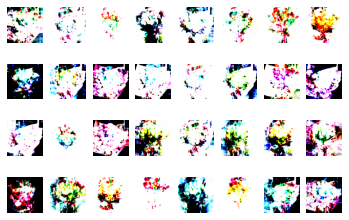

Обучение НС заняло:  1758.66 s


In [ ]:
# Обучаем нейросеть на 80000 эпохах (ниже - дообучение на последних 10000 эпохах)
train_cvae(CVAE,  epochs=10000, callbacks=[pltfig])

# 7. Проверка предикта CVAE

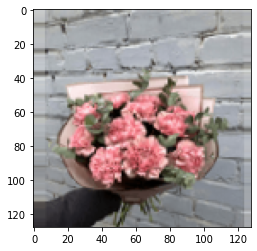

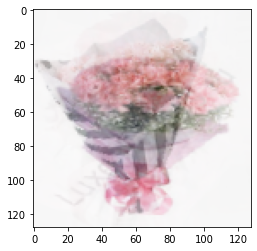

In [ ]:
real_img = xtest[:32] # берем батч изображений из x_test
real_img_nums = ytest[:32] # берем батч меток из x_test
i = 31 # определяем метку в пределах batch_size
pred_img = CVAE.predict([real_img, real_img_nums, real_img_nums]) # пропускаем их через CVA
plt.imshow(real_img[i].reshape(128,128,3 )) # выводим исходное изображение
plt.show() 
plt.imshow(pred_img[i].reshape(128,128,3 )) # выводим изображение предсказания
plt.show() 

# 8. Проверка работы декодера и сохранение моделей

In [ ]:
# выведем словарь наименований классов (характеристик букетов) и их числовые метки
print(valid.class_indices)

{'Glad_blue': 0, 'Glad_pink': 1, 'Glad_red': 2, 'Glad_white': 3, 'Glad_yellow': 4, 'Gvoz_blue': 5, 'Gvoz_pink': 6, 'Gvoz_red': 7, 'Gvoz_white': 8, 'Gvoz_yellow': 9, 'Hriz_pink': 10, 'Hriz_white': 11, 'Hriz_yellow': 12, 'Peon_pink': 13, 'Peon_red': 14, 'Peon_white': 15, 'Rose_pink': 16, 'Rose_red': 17, 'Rosw_white': 18, 'Tulp_blue': 19, 'Tulp_pink': 20, 'Tulp_red': 21, 'Tulp_white': 22, 'Tulp_yellow': 23}


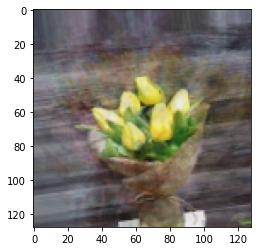

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор (шум по параметрам латентного пространства)
#plt.imshow(rand)
#plt.axis('off')
#plt.show()
dig = to_categorical(23, 24)[None, ...] # задаем номер класса в соответствии со словарем (23 - желтые тюльпаны)
predCVAE = decoder.predict([rand, dig]) # делаем predict декодера
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившeeся изображение
plt.show()
dig # для проверки - выводим метку класса в формате OHE

In [ ]:
# Сохраняем модель CVAE
CVAE.save('/content/drive/MyDrive/ДИПЛОМ AI/CVAE_2loss_ok1.h5') 
print("model saved!!!")

model saved!!!


In [ ]:
# Сохраняем модель decoder
decoder.save('/content/drive/MyDrive/ДИПЛОМ AI/dec_dense_ok1.h5') 
print("model saved!!!")

model saved!!!


Загрузка обученной модели

In [ ]:
from keras.models import load_model

# Для загрузки модель
custom_objects={'vae_loss':vae_loss,'Precision':Precision}

# Чтобы загрузить сохраненную модель, использующую vae_loss  и Precision
model1 = load_model('/content/drive/MyDrive/ДИПЛОМ AI/dec_dense_ok1.h5', custom_objects = custom_objects)
#model1.summary()

## 8.1.Проверка результатов декодера по всем классам

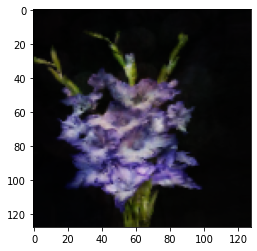

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(0, 24)[None, ...] # задаем lbl (0 - синие гладиолусы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

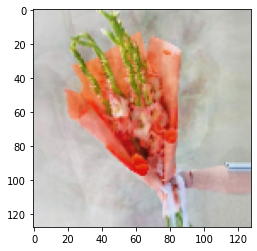

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(1, 24)[None, ...] # задаем lbl (1 - розовые гладиолусы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

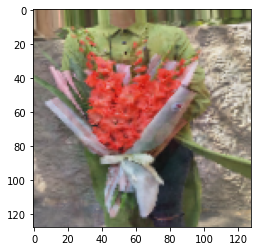

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(2, 24)[None, ...] # задаем lbl (2 - красные гладиолусы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

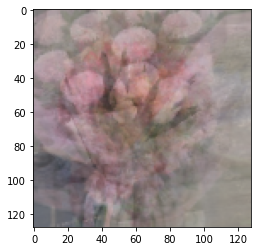

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(3, 24)[None, ...] # задаем lbl (3 - белые гладиолусы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

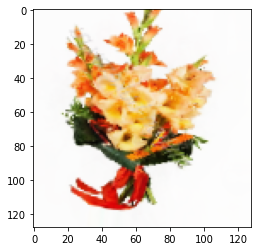

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(4, 24)[None, ...] # задаем lbl (4 - желтые гладиолусы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

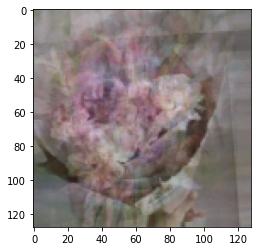

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(5, 24)[None, ...] # задаем lbl (5 - синие / фиолетовые гвоздики)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

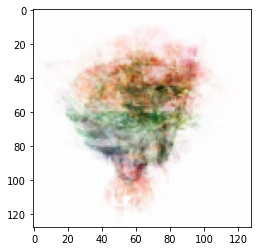

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(6, 24)[None, ...] # задаем lbl (6 - розовые гвоздики)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

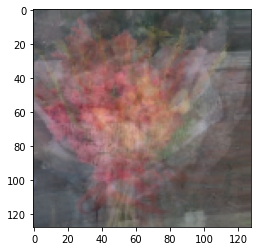

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(7, 24)[None, ...] # задаем lbl (7 - красные гвоздики)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

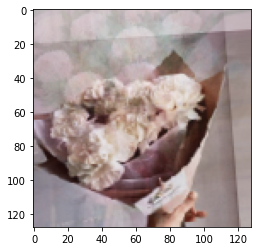

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(8, 24)[None, ...] # задаем lbl (8 - белые гвоздики)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

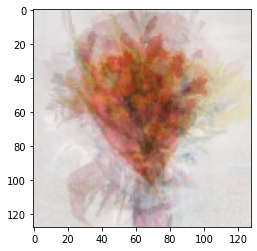

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(9, 24)[None, ...] # задаем lbl (9 - желтые гвоздики)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

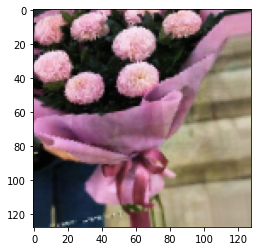

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(10, 24)[None, ...] # задаем lbl (10 - розовые хризантемы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

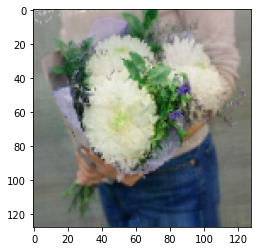

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(11, 24)[None, ...] # задаем lbl (11 - белые хризантемы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

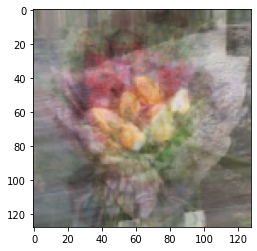

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(12, 24)[None, ...] # задаем lbl (12 - желтые хризантемы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

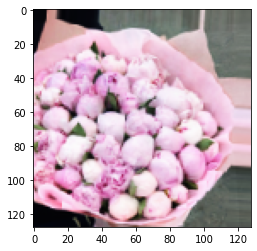

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(13, 24)[None, ...] # задаем lbl (13 - розовые пионы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

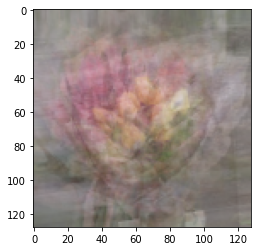

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(14, 24)[None, ...] # задаем lbl (14 - красные пионы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

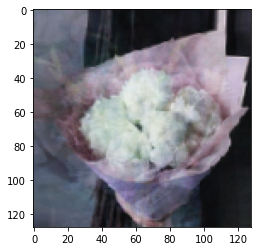

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(15, 24)[None, ...] # задаем lbl (15 - белые пионы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

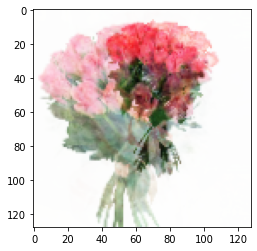

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(16, 24)[None, ...] # задаем lbl (16 - розовые розы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

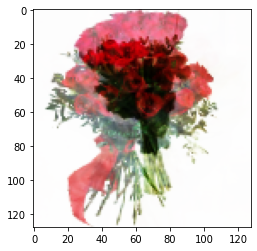

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(17, 24)[None, ...] # задаем lbl (17 - красные розы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

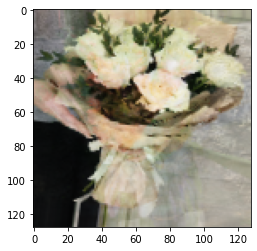

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(18, 24)[None, ...] # задаем lbl (18 - белые розы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

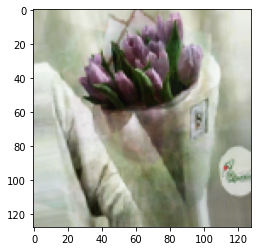

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(19, 24)[None, ...] # задаем lbl (19 - синие / фиолетовые тюльпаны)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

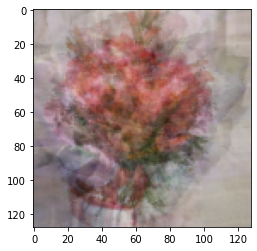

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(20, 24)[None, ...] # задаем lbl (20 - розовые тюльпаны)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

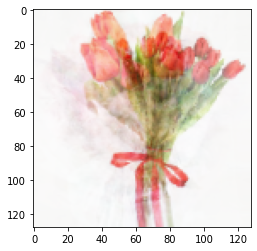

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(21, 24)[None, ...] # задаем lbl (21 - красные тюльпаны)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

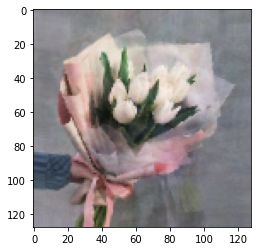

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(22, 24)[None, ...] # задаем lbl (22 - белые тюльпаны)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

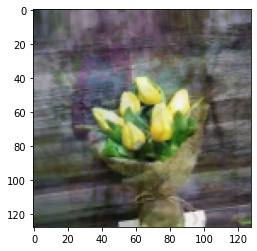

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(23, 24)[None, ...] # задаем lbl (23 - желтые тюльпаны)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

## 8.2. Вызов через задание параметров букета

Выберите название цветов для букета и введите соответствующее число: 

    гладиолусы - 1,  гвоздики - 2,  хризантемы - 3,  пионы - 4, розы - 5, тюльпаны - 6 
5
Выберите основной цвет букета и введите соответствующее число: 

    розовый - 1,  красный - 2,  белый - 3 
2


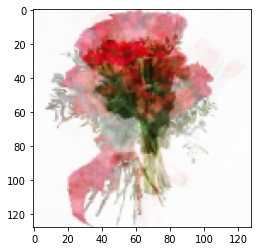

In [ ]:
# Зададим ввод параметров букета по желанию
n = int(input("""Выберите название цветов для букета и введите соответствующее число: \n
    гладиолусы - 1,  гвоздики - 2,  хризантемы - 3,  пионы - 4, розы - 5, тюльпаны - 6 \n"""))

if n==1:
  m1 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    фиолетовый - 1,  розовый - 2,  красный - 3,  белый - 4, желтый - 5 \n"""))
if n==2:
  m2 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
   фиолетовый - 1,  розовый - 2,  красный - 3,  белый - 4, желтый - 5 \n"""))
if n==3:
  m3 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    розовый - 1,  белый - 2, желтый - 3 \n"""))
if n==4:
  m4 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    розовый - 1,  красный - 2,  белый - 3 \n"""))  
if n==5:
  m5 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    розовый - 1,  красный - 2,  белый - 3 \n"""))
if n==6:
  m6 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    фиолетовый - 1,  розовый - 2,  красный - 3,  белый - 4, желтый - 5 \n"""))
# Определим номер класса по двум введенным признакам
if n==1:
    if m1==1:
      i=0
    if m1==2:
      i=1
    if m1==3:
      i=2
    if m1==4:
      i=3
    if m1==5:
      i=4
if n==2:
  if m2==1:
    i=5
  if  m2==2:
    i=6
  if  m2==3:
    i=7
  if m2==4:
    i=8
  if  m2==5:
    i=9
if n==3: 
  if m3==1:
    i=10
  if  m3==2:
    i=11
  if  m3==3:
    i=12
if n==4: 
  if m4==1:
    i=13
  if  m4==2:
    i=14
  if  m4==3:
    i=15
if n==5: 
  if m5==1:
    i=16
  if m5==2:
    i=17
  if m5==3:
    i=18
if n==6:
  if m6==1:
    i=19
  if  m6==2:
    i=20
  if  m6==3:
    i=21
  if  m6==4:
    i=22
  if  m6==5:
    i=23

#print(i)
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(i, 24)[None, ...] # задаем номер класса
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившееся изображение букета 
plt.show()  

## 8.3.Вызов изображения через функцию

In [ ]:
# Зададим ввод параметров букета по желанию
n = 0
i = 0
def print_bouquet(n,  i):
  n = int(input("""Выберите название цветов для букета и введите соответствующее число: \n
    гладиолусы - 1,  гвоздики - 2,  хризантемы - 3,  пионы - 4, розы - 5, тюльпаны - 6 \n"""))

  if n==1:
    m1 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    фиолетовый - 1,  розовый - 2,  красный - 3,  белый - 4, желтый - 5 \n"""))
  if n==2:
    m2 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
   фиолетовый - 1,  розовый - 2,  красный - 3,  белый - 4, желтый - 5 \n"""))
  if n==3:
    m3 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    розовый - 1,  белый - 2, желтый - 3 \n"""))
  if n==4:
    m4 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    розовый - 1,  красный - 2,  белый - 3 \n"""))  
  if n==5:
    m5 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    розовый - 1,  красный - 2,  белый - 3 \n"""))
  if n==6:
    m6 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    фиолетовый - 1,  розовый - 2,  красный - 3,  белый - 4, желтый - 5 \n"""))
# Определим номер класса по двум введенным признакам
  if n==1:
    if m1==1:
      i=0
    if m1==2:
      i=1
    if m1==3:
      i=2
    if m1==4:
      i=3
    if m1==5:
      i=4
  if n==2:
    if m2==1:
      i=5
    if  m2==2:
      i=6
    if  m2==3:
      i=7
    if m2==4:
      i=8
    if  m2==5:
      i=9
  if n==3: 
    if m3==1:
      i=10
    if  m3==2:
      i=11
    if  m3==3:
      i=12
  if n==4: 
    if m4==1:
      i=13
    if  m4==2:
      i=14
    if  m4==3:
      i=15
  if n==5: 
    if m5==1:
      i=16
    if m5==2:
      i=17
    if m5==3:
      i=18
  if n==6:
    if m6==1:
      i=19
    if  m6==2:
      i=20
    if  m6==3:
      i=21
    if  m6==4:
      i=22
    if  m6==5:
      i=23

  #print(i)
  rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
  plt.imshow(rand)
  plt.axis('off')
  plt.show()
  dig = to_categorical(i, 24)[None, ...] # задаем номер класса
  predCVAE = model1.predict([rand, dig])
  plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившееся изображение букета 
  plt.show()  
  return i

Выберите название цветов для букета и введите соответствующее число: 

    гладиолусы - 1,  гвоздики - 2,  хризантемы - 3,  пионы - 4, розы - 5, тюльпаны - 6 
3
Выберите основной цвет букета и введите соответствующее число: 

    розовый - 1,  белый - 2, желтый - 3 
1


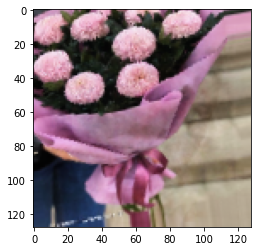

10

In [ ]:
print_bouquet(n,  i)

# Выводы

1. Цель работы "Генерация букетов с заданными цветами" достигнута с точностью (по классу) 60-75(условно) процентов.
2. Улучшение результатов возможно при пополнении базы изображений и ее балансировке, дообучении модели, а также, возможно, применении более "продвинутых" архитектур нейросети